
# Combine predictors using stacking

.. currentmodule:: sklearn

Stacking refers to a method to blend estimators. In this strategy, some
estimators are individually fitted on some training data while a final
estimator is trained using the stacked predictions of these base estimators.

In this example, we illustrate the use case in which different regressors are
stacked together and a final linear penalized regressor is used to output the
prediction. We compare the performance of each individual regressor with the
stacking strategy. Stacking slightly improves the overall performance.


In [1]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
#          Maria Telenczuk    <https://github.com/maikia>
# License: BSD 3 clause

## Download the dataset

 We will use the `Ames Housing`_ dataset which was first compiled by Dean De Cock
 and became better known after it was used in Kaggle challenge. It is a set
 of 1460 residential homes in Ames, Iowa, each described by 80 features. We
 will use it to predict the final logarithmic price of the houses. In this
 example we will use only 20 most interesting features chosen using
 GradientBoostingRegressor() and limit number of entries (here we won't go
 into the details on how to select the most interesting features).

 The Ames housing dataset is not shipped with scikit-learn and therefore we
 will fetch it from `OpenML`_.




In [2]:
import numpy as np

import time

import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle


def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target

    # features = [
    #     "YrSold",
    #     "HeatingQC",
    #     "Street",
    #     "YearRemodAdd",
    #     "Heating",
    #     "MasVnrType",
    #     "BsmtUnfSF",
    #     "Foundation",
    #     "MasVnrArea",
    #     "MSSubClass",
    #     "ExterQual",
    #     "Condition2",
    #     "GarageCars",
    #     "GarageType",
    #     "OverallQual",
    #     "TotalBsmtSF",
    #     "BsmtFinSF1",
    #     "HouseStyle",
    #     "MiscFeature",
    #     "MoSold",
    # ]

    # X = X.loc[:, features]
    X, y = shuffle(X, y, random_state=0)

    # X = X.iloc[:600]
    # y = y.iloc[:600]
    return X, np.log(y)


X, y = load_ames_housing()

## Make pipeline to preprocess the data

 Before we can use Ames dataset we still need to do some preprocessing.
 First, we will select the categorical and numerical columns of the dataset to
 construct the first step of the pipeline.



In [3]:

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X)

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [4]:
num_selector(X)

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

Then, we will need to design preprocessing pipelines which depends on the
ending regressor. If the ending regressor is a linear model, one needs to
one-hot encode the categories. If the ending regressor is a tree-based model
an ordinal encoder will be sufficient. Besides, numerical values need to be
standardized for a linear model while the raw numerical data can be treated
as is by a tree-based model. However, both models need an imputer to
handle missing values.

We will first design the pipeline required for the tree-based models.



In [5]:


cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f17c39d0250>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1843940b90>)])

Then, we will now define the preprocessor used when the ending regressor
is a linear model.



In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f17c39d0250>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1843940b90>)])

## Stack of predictors on a single data set

 It is sometimes tedious to find the model which will best perform on a given
 dataset. Stacking provide an alternative by combining the outputs of several
 learners, without the need to choose a model specifically. The performance of
 stacking is usually close to the best model and sometimes it can outperform
 the prediction performance of each individual model.

 Here, we combine 3 learners (linear and non-linear) and use a ridge regressor
 to combine their outputs together.

 .. note::
    Although we will make new pipelines with the processors which we wrote in
    the previous section for the 3 learners, the final estimator
    :class:`~sklearn.linear_model.RidgeCV()` does not need preprocessing of
    the data as it will be fed with the already preprocessed output from the 3
    learners.



In [7]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f17c39d0250>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1843940b90>)])),
                ('lassocv', LassoCV())])

In [8]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f17c39d0250>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1843940b90>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f17c39d0250>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1843940b90>)])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(random_state=0))])

In [10]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

StackingRegressor(estimators=[('Random Forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f17c39d0250>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_v...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f17c39d0250>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1843940b90>)])),
                                               ('histgradientboostingregressor',
                                                HistGradientBoostingRegressor(random_state=0))]))],
                  final_estimator=RidgeCV())

## Measure and plot the results

 Now we can use Ames Housing dataset to make the predictions. We check the
 performance of each individual predictor as well as of the stack of the
 regressors.



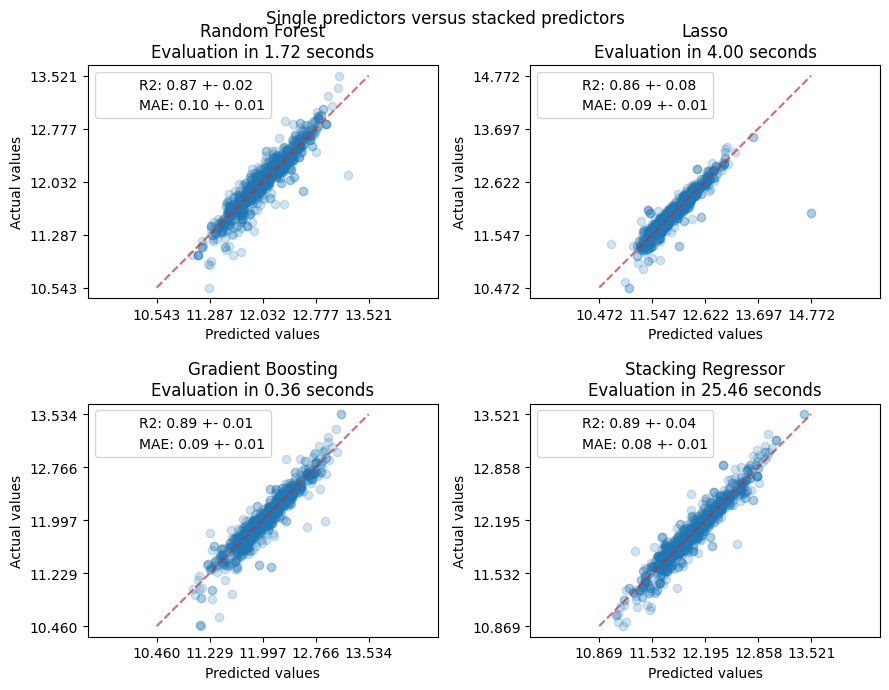

In [11]:


fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The stacked regressor will combine the strengths of the different regressors.
However, we also see that training the stacked regressor is much more
computationally expensive.

